In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [4]:
root_path = "/kaggle/input/gtsrb-german-traffic-sign"
train_df = pd.read_csv(os.path.join(root_path, "Train.csv"))
print(train_df.head())

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  


In [5]:
IMG_SIZE = 64

def preprocess_img(img_path, roi):
    img = cv2.imread(img_path)
    if img is None:
        return None
    2
    x1, y1, x2, y2 = roi
    img = img[y1:y2, x1:x2]
    
    # Resize + Normalize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

images, labels = [], []

for i, row in train_df.iterrows():
    img_path = os.path.join(root_path, row['Path'])
    roi = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
    
    img = preprocess_img(img_path, roi)
    if img is not None:
        images.append(img)
        labels.append(row['ClassId'])

X = np.array(images)
y = np.array(labels)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (39209, 64, 64, 3) (39209,)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)

Number of classes: 43


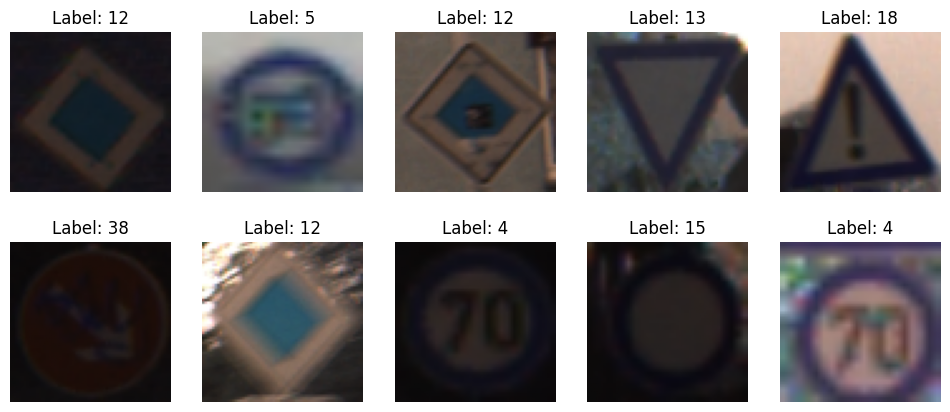

In [7]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.show()

In [8]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757370794.763597      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757370794.764397      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,219 (9.38 MB)

 Trainable params: 2,458,219 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [10]:
history_cnn = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757370800.194492     104 service.cc:148] XLA service 0x7bce68005f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757370800.195819     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757370800.195845     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757370800.526325     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/491 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - accuracy: 0.0280 - loss: 3.7602

I0000 00:00:1757370803.693157     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


491/491 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.2992 - loss: 2.5803 - val_accuracy: 0.8341 - val_loss: 0.6497
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.6627 - loss: 1.0476 - val_accuracy: 0.9555 - val_loss: 0.2072
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.7872 - loss: 0.6635 - val_accuracy: 0.9735 - val_loss: 0.1187
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.8539 - loss: 0.4602 - val_accuracy: 0.9883 - val_loss: 0.0562
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.8853 - loss: 0.3645 - val_accuracy: 0.9907 - val_loss: 0.0386
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.9052 - loss: 0.2989 - val_accuracy: 0.9904 - val_loss: 0.0354
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.9209 - loss: 0.2493 - val_accuracy: 0.9943 - val_loss: 0.0263
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.9324 - loss: 0.2131 - val_accurac

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9961 - loss: 0.0141
CNN Validation Accuracy: 0.9957
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


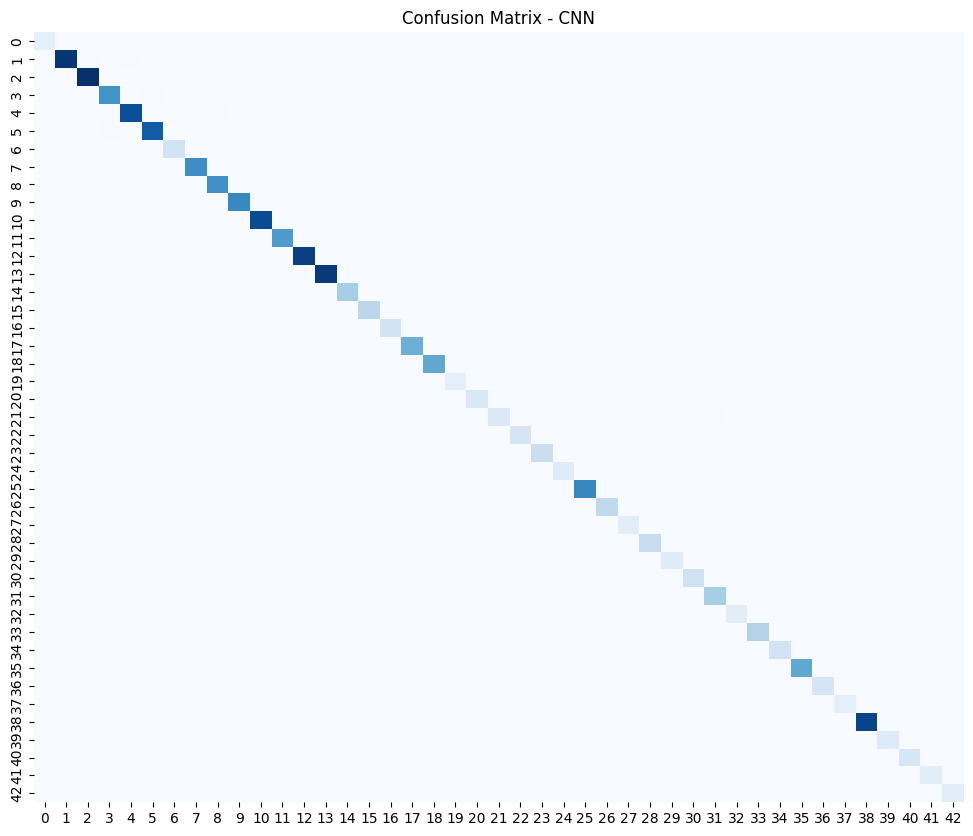

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      0.98      0.99       444
           2       0.99      1.00      0.99       450
           3       0.99      0.98      0.99       282
           4       0.99      0.99      0.99       396
           5       0.98      0.99      0.99       372
           6       1.00      1.00      1.00        84
           7       1.00      0.99      0.99       288
           8       0.98      1.00      0.99       282
           9       1.00      1.00      1.00       294
          10       1.00      1.00      1.00       402
          11       1.00      1.00      1.00       264
          12       1.00      1.00      1.00       420
          13       1.00      1.00      1.00       432
          14       1.00      1.00      1.00       156
          15       1.00      1.00      1.00       126
          16       1.00      1.00      1.00        84
          17       1.00    

In [11]:
val_loss, val_acc = cnn_model.evaluate(X_val, y_val)
print(f"CNN Validation Accuracy: {val_acc:.4f}")

y_pred_cnn = cnn_model.predict(X_val).argmax(axis=1)
cm_cnn = confusion_matrix(y_val, y_pred_cnn)

plt.figure(figsize=(12,10))
sns.heatmap(cm_cnn, cmap="Blues", cbar=False)
plt.title("Confusion Matrix - CNN")
plt.show()

print(classification_report(y_val, y_pred_cnn))

### **MobileNetV2 Transfer Learning**

In [12]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')
base_model.trainable = False  # freeze layers

mobilenet_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/tmp/ipykernel_36/153901478.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
mobilenet_model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,499 (9.26 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
history_mobile = mobilenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 56s 94ms/step - accuracy: 0.3228 - loss: 2.5141 - val_accuracy: 0.6183 - val_loss: 1.1829
Epoch 2/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.5440 - loss: 1.4300 - val_accuracy: 0.6894 - val_loss: 0.9781
Epoch 3/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.5958 - loss: 1.2339 - val_accuracy: 0.7151 - val_loss: 0.8840
Epoch 4/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.6222 - loss: 1.1475 - val_accuracy: 0.7369 - val_loss: 0.8163
Epoch 5/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.6301 - loss: 1.1017 - val_accuracy: 0.7487 - val_loss: 0.7631
Epoch 6/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.6495 - loss: 1.0595 - val_accuracy: 0.7517 - val_loss: 0.7363
Epoch 7/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 74ms/step - accuracy: 0.6553 - loss: 1.0284 - val_accuracy: 0.7719 - val_loss: 0.6954
Epoch 8/30
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.6668 - loss: 1.0044 - val_accurac

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8261 - loss: 0.5226
MobileNetV2 Validation Accuracy: 0.8201
246/246 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step


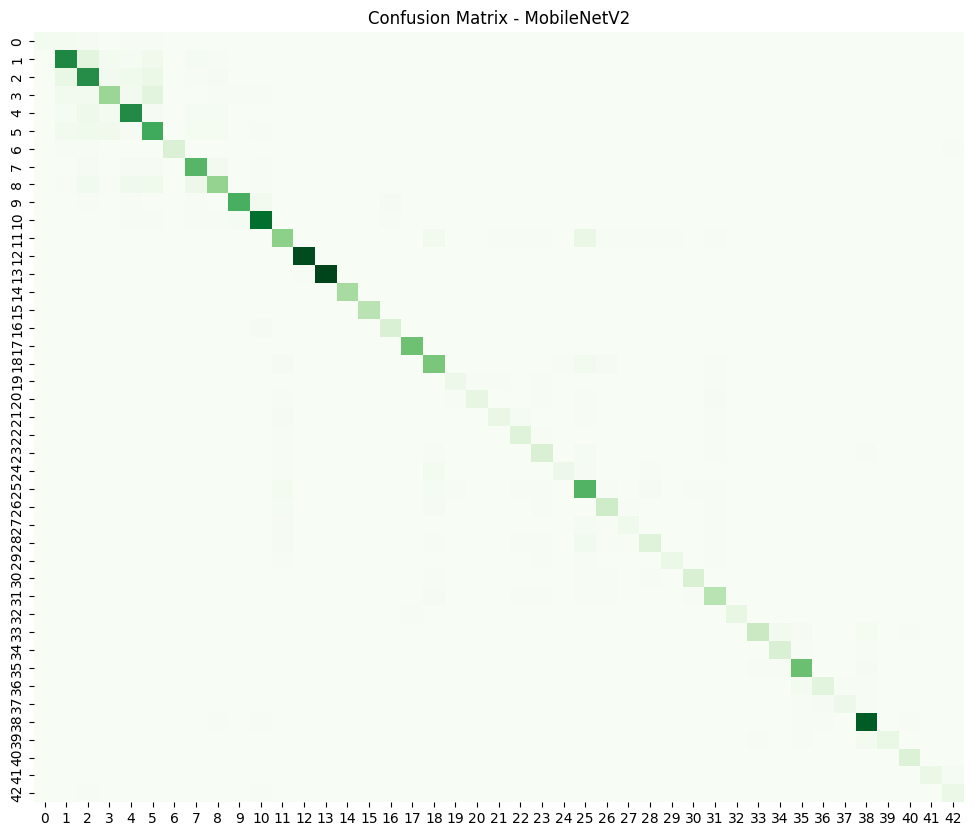

              precision    recall  f1-score   support

           0       1.00      0.31      0.47        42
           1       0.76      0.74      0.75       444
           2       0.66      0.70      0.68       450
           3       0.70      0.60      0.65       282
           4       0.77      0.81      0.79       396
           5       0.62      0.73      0.67       372
           6       0.95      0.86      0.90        84
           7       0.77      0.85      0.81       288
           8       0.77      0.62      0.69       282
           9       0.94      0.88      0.91       294
          10       0.90      0.93      0.91       402
          11       0.73      0.70      0.72       264
          12       0.99      1.00      0.99       420
          13       0.99      0.99      0.99       432
          14       0.97      0.99      0.98       156
          15       0.98      1.00      0.99       126
          16       0.87      0.89      0.88        84
          17       0.98    

In [15]:
val_loss_m, val_acc_m = mobilenet_model.evaluate(X_val, y_val)
print(f"MobileNetV2 Validation Accuracy: {val_acc_m:.4f}")

y_pred_mobile = mobilenet_model.predict(X_val).argmax(axis=1)
cm_mobile = confusion_matrix(y_val, y_pred_mobile)

plt.figure(figsize=(12,10))
sns.heatmap(cm_mobile, cmap="Greens", cbar=False)
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

print(classification_report(y_val, y_pred_mobile))

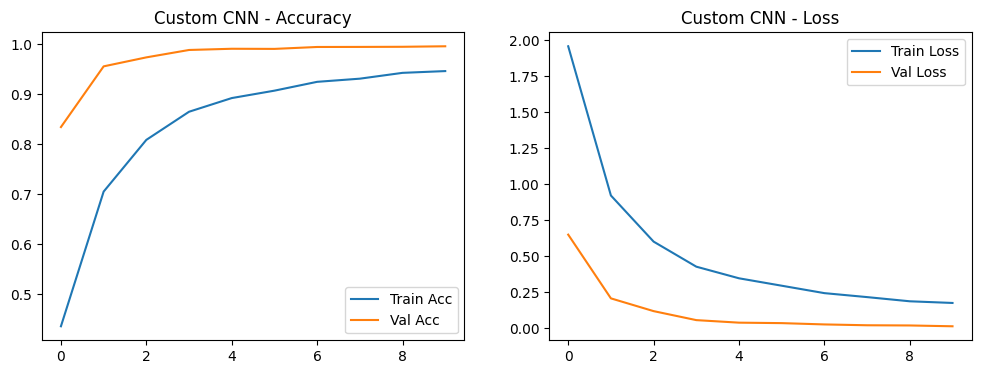

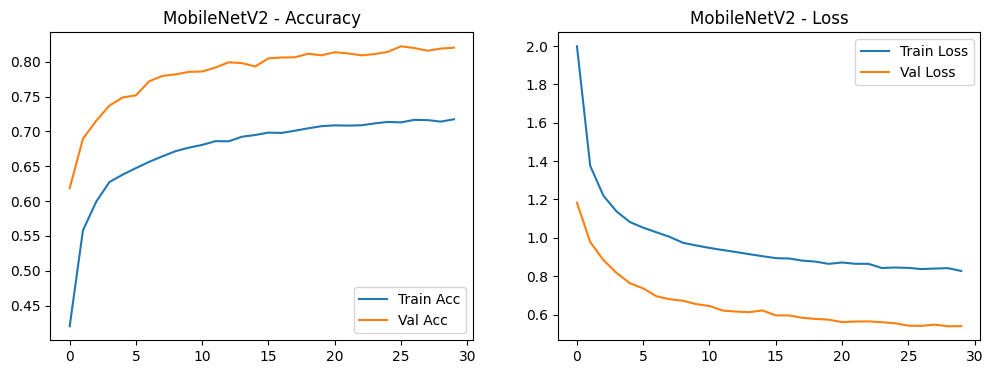

In [16]:
def plot_history(history, title):
    plt.figure(figsize=(12,4))
    
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label="Train Acc")
    plt.plot(history.history['val_accuracy'], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    
    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label="Train Loss")
    plt.plot(history.history['val_loss'], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    
    plt.show()

plot_history(history_cnn, "Custom CNN")
plot_history(history_mobile, "MobileNetV2")

In [17]:
print(f"Custom CNN Accuracy: {val_acc:.4f}")
print(f"MobileNetV2 Accuracy: {val_acc_m:.4f}")

Custom CNN Accuracy: 0.9957
MobileNetV2 Accuracy: 0.8201


In [18]:
cnn_model.save("/kaggle/working/cnn_model.h5")
mobilenet_model.save("/kaggle/working/mobilenet_model.h5")

In [21]:
print(cnn_model.input_shape)
print(mobilenet_model.input_shape)

(None, 64, 64, 3)
(None, 64, 64, 3)


In [22]:
import os
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ==============================
# 1. Load your models
# ==============================
cnn_model = load_model("/kaggle/working/cnn_model.h5")
mobilenet_model = load_model("/kaggle/working/mobilenet_model.h5")

# ==============================
# 2. Class Labels
# ==============================
classes = {
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

# ==============================
# 3. Preprocessing Function
# ==============================
def preprocess_img(img):
    img = img.resize((64, 64))   # both models trained on 64x64
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# ==============================
# 4. Prediction Functions
# ==============================
def predict_cnn(img):
    img_array = preprocess_img(img)
    preds = cnn_model.predict(img_array)
    pred_class = int(np.argmax(preds, axis=1)[0])
    return {classes.get(pred_class, "Unknown"): float(np.max(preds))}

def predict_mobilenet(img):
    img_array = preprocess_img(img)
    preds = mobilenet_model.predict(img_array)
    pred_class = int(np.argmax(preds, axis=1)[0])
    return {classes.get(pred_class, "Unknown"): float(np.max(preds))}

# Compare both models
def compare_models(img):
    cnn_preds = cnn_model.predict(preprocess_img(img))
    mobilenet_preds = mobilenet_model.predict(preprocess_img(img))

    cnn_class = int(np.argmax(cnn_preds, axis=1)[0])
    mobilenet_class = int(np.argmax(mobilenet_preds, axis=1)[0])

    return {
        "CNN Prediction": classes.get(cnn_class, "Unknown"),
        "MobileNet Prediction": classes.get(mobilenet_class, "Unknown")
    }


# ==============================
# 5. Gradio Interface
# ==============================
os.environ["GRADIO_LOCALE"] = "en"

interface = gr.Interface(
    fn=compare_models,
    inputs=gr.Image(type="pil"),
    outputs=gr.JSON(),
    title="🚦 Traffic Sign Classifier",
    description="Upload a traffic sign image and compare predictions between a custom CNN (32×32) and MobileNet (64×64)."
)

# Works inside Kaggle notebook
interface.launch(inline=True)


* Running on local URL:  http://127.0.0.1:7862
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://8a1384dfd36ea34b88.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
